In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

In [34]:
dfs = {}
for year in ['2023', '2024']:
    for filename in os.listdir(year):
        name = filename.split('_')[1].split('.')[0]
        dfs[name] = pd.read_csv(f'{year}/{filename}')
        dfs[name]['DATE'] = pd.to_datetime(dfs[name]['DATE'])
        dfs[name]['DATE'] = dfs[name].apply(lambda row: row['DATE'] + timedelta(minutes = 30 * (row['PERIOD'] - 1)), axis = 1)
        dfs[name] = dfs[name].drop(columns = ['INFORMATION TYPE', 'PERIOD', 'SOLAR(MW)'])

In [35]:
df = dfs['Apr-2023']
df.head(2)

,DATE,USEP ($/MWh),LCP ($/MWh),DEMAND (MW),TCL(MW)
0,2023-04-01 00:00:00,156.64,0.0,5863.944,0.0
1,2023-04-01 00:30:00,203.80,0.0,5774.836,0.0


In [36]:
dfs.keys()

dict_keys(['May-2023', 'Jul-2023', 'Dec-2023', 'Sep-2023', 'Oct-2023', 'Jun-2023', 'Aug-2023', 'Mar-2023', 'Feb-2023', 'Nov-2023', 'Jan-2023', 'Apr-2023', 'Oct-2024', 'Jan-2024', 'Jun-2024', 'Jul-2024', 'Sep-2024', 'May-2024', 'Dec-2024', 'Apr-2024', 'Nov-2024', 'Feb-2024', 'Mar-2024', 'Aug-2024'])

In [37]:
df = dfs['Apr-2023']

In [38]:
dfs['Apr-2023'].head()

,DATE,USEP ($/MWh),LCP ($/MWh),DEMAND (MW),TCL(MW)
0,2023-04-01 00:00:00,156.64,0.0,5863.944,0.0
1,2023-04-01 00:30:00,203.80,0.0,5774.836,0.0
2,2023-04-01 01:00:00,167.31,0.0,5689.909,0.0
3,2023-04-01 01:30:00,177.07,0.0,5652.912,0.0
4,2023-04-01 02:00:00,156.56,0.0,5592.661,0.0


<Axes: xlabel='DATE'>

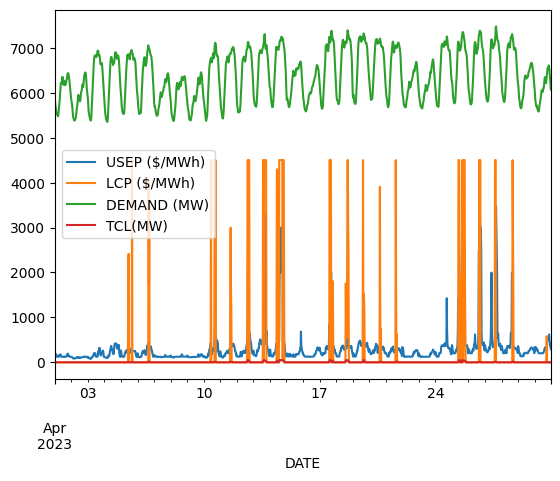

In [39]:
df.set_index('DATE').plot()

<Axes: xlabel='DATE'>

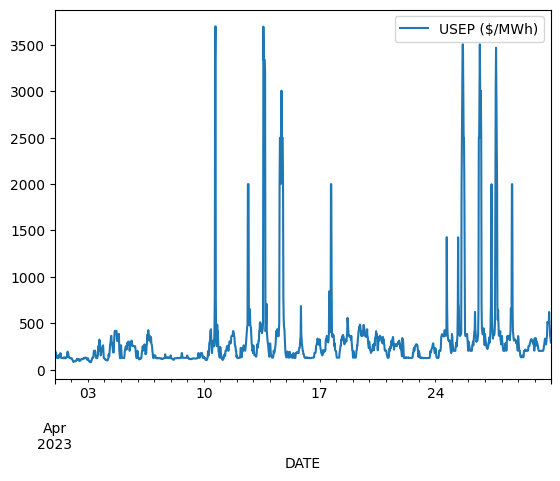

In [40]:
dfs['Apr-2023'].plot(x="DATE", y='USEP ($/MWh)')

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Univariate Random Forest Time Prediction

Root Mean Squared Error (RMSE): 332.2232641131053


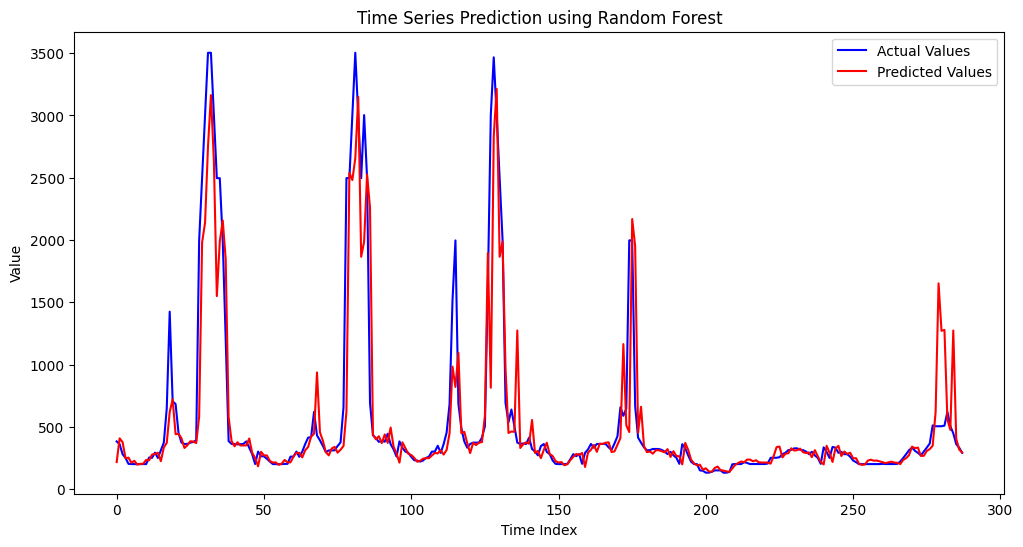

In [42]:
x_col, y_col = 'DATE', 'USEP ($/MWh)'
data = df[[x_col, y_col]].copy()
data.set_index(x_col, inplace=True)

# 2. Create lag features
def create_lag_features(data, lags=3):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"value_lag{lag}"] = df[y_col].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values (from shifting)
    return df

lagged_data = create_lag_features(data, lags=3)

# 3. Prepare the training and test sets
X = lagged_data.drop(columns=[y_col])
y = lagged_data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train a regression model (Random Forest in this case)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 6. Make predictions
y_pred = model.predict(X_test_scaled)

# 7. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 8. Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Values", color="blue")
plt.plot(y_pred, label="Predicted Values", color="red")
plt.title("Time Series Prediction using Random Forest")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.show()


# Multivariate Random Forest Time Series

In [43]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [44]:
df.head(1)

,DATE,USEP ($/MWh),LCP ($/MWh),DEMAND (MW),TCL(MW)
0,2023-04-01,156.64,0.0,5863.944,0.0


In [65]:
data.iloc[:,1:]

,LCP ($/MWh),DEMAND (MW),TCL(MW)
DATE,,,
2023-04-01 00:00:00,0.0,5863.944,0.0
2023-04-01 00:30:00,0.0,5774.836,0.0
2023-04-01 01:00:00,0.0,5689.909,0.0
2023-04-01 01:30:00,0.0,5652.912,0.0
2023-04-01 02:00:00,0.0,5592.661,0.0
...,...,...,...
2023-04-30 21:30:00,0.0,6496.123,0.0
2023-04-30 22:00:00,0.0,6399.949,0.0
2023-04-30 22:30:00,0.0,6288.526,0.0


Epoch [10/100], Loss: 0.0119
Epoch [20/100], Loss: 0.0097
Epoch [30/100], Loss: 0.0082
Epoch [40/100], Loss: 0.0075
Epoch [50/100], Loss: 0.0070
Epoch [60/100], Loss: 0.0067
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0062
Epoch [90/100], Loss: 0.0061
Epoch [100/100], Loss: 0.0060


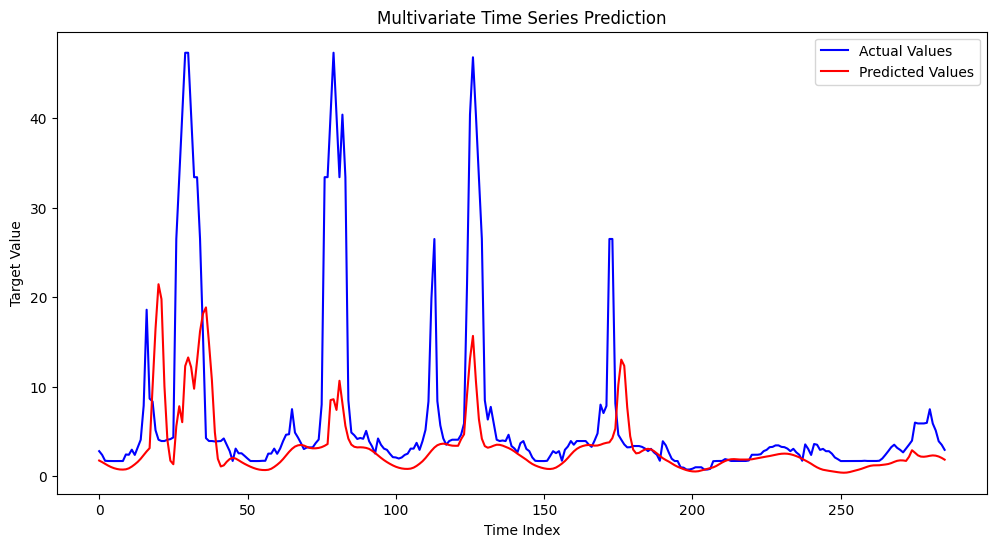

In [61]:
# 1. Generate sample multivariate time series data
np.random.seed(42)
time = pd.date_range(start="2022-01-01", periods=200, freq="D")

# Generate multiple features
feature_1 = np.sin(np.arange(200) * 0.1) + np.random.normal(0, 0.1, 200)
feature_2 = np.cos(np.arange(200) * 0.1) + np.random.normal(0, 0.1, 200)
target = feature_1 * 0.6 + feature_2 * 0.4 + np.random.normal(0, 0.1, 200)

data = pd.DataFrame({"feature_1": feature_1, "feature_2": feature_2, "target": target}, index=time)

target = 'USEP ($/MWh)'
num_features = 3
data = df.copy()
data.set_index('DATE', inplace=True)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# 3. Prepare data for supervised learning
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length, 1:].values)  # Use all columns except the target
        y.append(data.iloc[i+sequence_length][target_column])  # Use the target column
    return np.array(X), np.array(y)

sequence_length = 10  # Lookback window
X, y = create_sequences(scaled_data, target_column=target, sequence_length=sequence_length)

# 4. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# 5. Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        out, _ = self.lstm(x)  # LSTM outputs and hidden states
        # Fully connected layer (only take the last output of the sequence)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 6. Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 7. Train the model
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 8. Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 9. Inverse scale the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), num_features)), y_pred.numpy()])[:, -1]
y_test_rescaled = scaler.inverse_transform(np.c_[np.zeros((len(y_test), num_features)), y_test.numpy()])[:, -1]

# 10. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Values", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Values", color="red")
plt.title("Multivariate Time Series Prediction")
plt.xlabel("Time Index")
plt.ylabel("Target Value")
plt.legend()
plt.show()


Epoch [10/100], Loss: 0.0132
Epoch [20/100], Loss: 0.0100
Epoch [30/100], Loss: 0.0088
Epoch [40/100], Loss: 0.0076
Epoch [50/100], Loss: 0.0072
Epoch [60/100], Loss: 0.0066
Epoch [70/100], Loss: 0.0062
Epoch [80/100], Loss: 0.0057
Epoch [90/100], Loss: 0.0052
Epoch [100/100], Loss: 0.0049


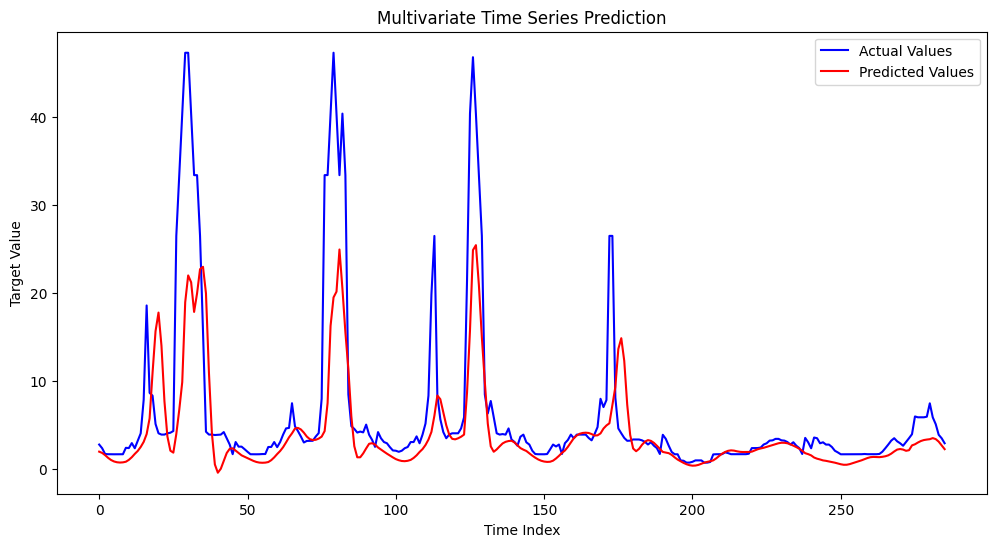

In [66]:
# 1. Generate sample multivariate time series data
np.random.seed(42)
time = pd.date_range(start="2022-01-01", periods=200, freq="D")

# Generate multiple features
feature_1 = np.sin(np.arange(200) * 0.1) + np.random.normal(0, 0.1, 200)
feature_2 = np.cos(np.arange(200) * 0.1) + np.random.normal(0, 0.1, 200)
target = feature_1 * 0.6 + feature_2 * 0.4 + np.random.normal(0, 0.1, 200)

data = pd.DataFrame({"feature_1": feature_1, "feature_2": feature_2, "target": target}, index=time)

target = 'USEP ($/MWh)'
num_features = 3
data = df.copy()
data.set_index('DATE', inplace=True)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# 3. Prepare data for supervised learning
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length, :-1].values)  # Use all columns except the target
        y.append(data.iloc[i+sequence_length][target_column])  # Use the target column
    return np.array(X), np.array(y)

sequence_length = 10  # Lookback window
X, y = create_sequences(scaled_data, target_column=target, sequence_length=sequence_length)

# 4. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# 5. Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        out, _ = self.lstm(x)  # LSTM outputs and hidden states
        # Fully connected layer (only take the last output of the sequence)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 6. Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 7. Train the model
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 8. Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 9. Inverse scale the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), num_features)), y_pred.numpy()])[:, -1]
y_test_rescaled = scaler.inverse_transform(np.c_[np.zeros((len(y_test), num_features)), y_test.numpy()])[:, -1]

# 10. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Values", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Values", color="red")
plt.title("Multivariate Time Series Prediction")
plt.xlabel("Time Index")
plt.ylabel("Target Value")
plt.legend()
plt.show()


# Using Full Data

In [55]:
# Append all DataFrames together
combined_df = pd.concat(dfs.values())
combined_df = combined_df.sort_values(by="DATE")

Epoch [10/100], Loss: 0.0052
Epoch [20/100], Loss: 0.0049
Epoch [30/100], Loss: 0.0046
Epoch [40/100], Loss: 0.0045
Epoch [50/100], Loss: 0.0044
Epoch [60/100], Loss: 0.0044
Epoch [70/100], Loss: 0.0043
Epoch [80/100], Loss: 0.0043
Epoch [90/100], Loss: 0.0043
Epoch [100/100], Loss: 0.0043


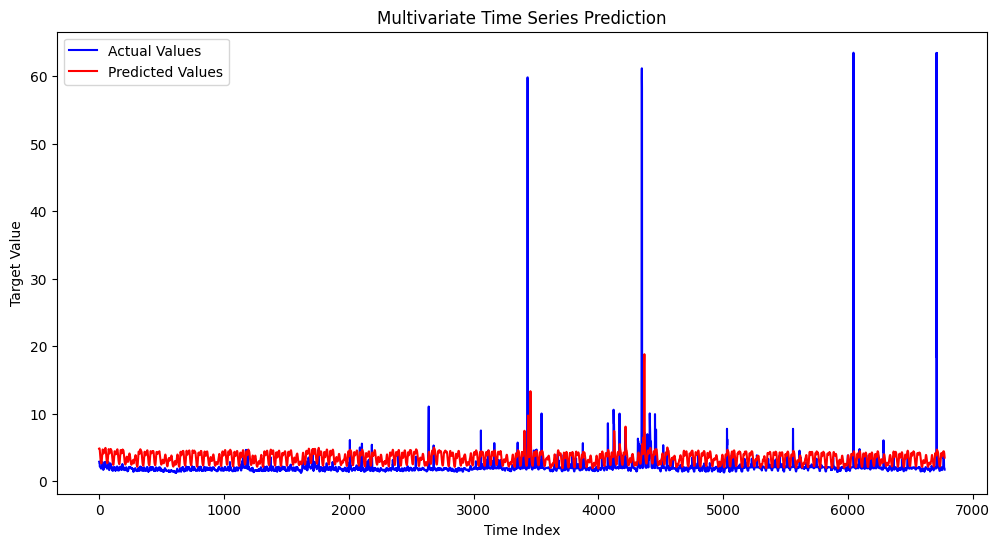

In [60]:
target = 'USEP ($/MWh)'
num_features = 3
data = combined_df.copy()
data.set_index('DATE', inplace=True)

# 2. Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# 3. Prepare data for supervised learning
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length, 1:].values)  # Use all columns except the target
        y.append(data.iloc[i+sequence_length][target_column])  # Use the target column
    return np.array(X), np.array(y)

sequence_length = 10  # Lookback window
X, y = create_sequences(scaled_data, target_column=target, sequence_length=sequence_length)

# 4. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# 5. Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        out, _ = self.lstm(x)  # LSTM outputs and hidden states
        # Fully connected layer (only take the last output of the sequence)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 6. Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 7. Train the model
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 8. Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 9. Inverse scale the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), num_features)), y_pred.numpy()])[:, -1]
y_test_rescaled = scaler.inverse_transform(np.c_[np.zeros((len(y_test), num_features)), y_test.numpy()])[:, -1]

# 10. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Values", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Values", color="red")
plt.title("Multivariate Time Series Prediction")
plt.xlabel("Time Index")
plt.ylabel("Target Value")
plt.legend()
plt.show()
